<img src="https://raw.githubusercontent.com/PriyeshGosai/pypsa-meets-earth-lab-2025/main/img/top-banner.png" alt="Top Banner" width="100%">

<div style="display: flex; align-items: center; justify-content: space-between; gap: 30px;">
  <div>
    <h3 style="margin-top: 0;">Session Instructor</h3>
    <p style="margin: 5px 0; font-size: 20px;"><strong>Priyesh Gosai</strong></p>
    <p style="margin: 2px 0; font-size: 14px;">PAS-SA • Director: Energy Systems</p>
    <hr style="margin: 12px 0; border: none; border-top: 1px solid #000000ff;">
    <p style="margin: 6px 0; font-size: 13px;"><a href="mailto:pgosai@pas-sa.co.za">pgosai@pas-sa.co.za</a></p>
    <p style="margin: 6px 0; font-size: 13px;"><a href="https://www.linkedin.com/in/gosaip/">LinkedIn</a> | <a href="https://github.com/PriyeshGosai">GitHub</a> | <a href="https://www.pas-sa.co.za">Website</a></p>
  </div>
  <div>
    <a href="https://pas-sa.co.za/">
      <img src="https://raw.githubusercontent.com/PriyeshGosai/pypsa-meets-earth-lab-2025/main/img/pas-sa-logo.png" width="160" alt="PAS-SA">
    </a>
  </div>
</div>


# **Part 3: Compare scenarios**

## Install packages for Google Colab

In [1]:
#@title Connect to Google Drive {display-mode:"form"}
CONNECT_TO_DRIVE = False #@param {type:"boolean"}

from google.colab import drive
import os

if CONNECT_TO_DRIVE:
    # Mount Google Drive
    drive.mount('/content/drive')

    # Define the desired working directory path
    working_dir = '/content/drive/MyDrive/hello-pypsa'

    # Create the directory if it doesn't exist
    if not os.path.exists(working_dir):
        os.makedirs(working_dir)
        print(f"Directory '{working_dir}' created.")
    else:
        print(f"Directory '{working_dir}' already exists.")

    # Change the current working directory
    os.chdir(working_dir)

    print(f"Current working directory: {os.getcwd()}")
else:
    print("Not connecting to Google Drive.")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import os

#@title Install Packages {display-mode:"form"}
INSTALL_PACKAGES = True #@param {type:"boolean"}

# Check if packages have already been installed in this session to prevent re-installation
if INSTALL_PACKAGES and not os.environ.get('PYPSA_PACKAGES_INSTALLED'):
  !pip install pypsa pypsa[excel] folium mapclassify cartopy
  os.environ['PYPSA_PACKAGES_INSTALLED'] = 'true'
elif not INSTALL_PACKAGES:
  print("Skipping package installation.")
else:
  print("PyPSA packages are already installed for this session.")

In [3]:
#@title Download the file for this notebook {display-mode:"form"}
DOWNLOAD_FILE = True #@param {type:"boolean"}

if DOWNLOAD_FILE:
    !wget https://github.com/PriyeshGosai/pypsa-meets-earth-lab-2025/raw/main/network_ZA.xlsx -O network_ZA_scenario.xlsx
else:
    print("Skipping file download.")

'wget' is not recognized as an internal or external command,
operable program or batch file.


# Exercise 4

In this example we run all seven scenarios from exercise 3 and compare the results.


**Disclaimer**

This analysis employs a South African energy system case study developed exclusively for educational purposes. The model has been intentionally simplified and should not be construed as an accurate or comprehensive representation of the contemporary South African energy system. Consequently, this model is not suitable for application in substantive studies, policy analysis, or operational assessments pertaining to the South African power system.

**Data Sources**

The development of this model incorporates data and information from the following sources:

* DeSantis, D., James, B.D., Houchins, C., Saur, G. and Lyubovsky, M. (2021) 'Cost of long-distance energy transmission by different carriers', *IScience*, 24(12).

* Electric Power Research Institute (EPRI) (2024) 'Supply-Side Cost and Performance Data for Eskom Integrated Resource Planning: 2023–2024 Update', Technical Report 3002031032. Palo Alto, California: EPRI.

* Eskom Transmission Division (2020) *Transmission Development Plan 2020–2029*. Johannesburg, South Africa: Eskom Holdings SOC.

* Merven, B. (2024) 'ESRG Hourly Demand Model v2025 by Province', September. doi: 10.25375/uct.26942134.v5

* Eskom Holdings SOC Ltd (2025) *Eskom*. Available at: https://www.eskom.co.za (Accessed: 24 November 2025).

* Meridian Economics (n.d.) *PyPSA-RSA: An Open Optimisation Model of the South African Power System*. Available at: https://github.com/MeridianEconomics/pypsa-rsa

## Import network

In [26]:
import pypsa
import pandas as pd
import numpy as np
import pandas as pd

pd.set_option('plotting.backend', 'plotly')
pypsa.options.api.new_components_api = True
n_ZA = pypsa.Network('network_ZA_scenario.xlsx')

lcoe_ZAR_MW_dict = {'coal':140e6,'gas':10e6,'solar':20e6,'wind':27e6,'battery':26e6}
discount_rate_dict = {'coal':0.08,'gas':0.08,'solar':0.12,'wind':0.12,'battery':0.12}
investment_period = {'coal':40,'gas':20,'solar':15,'wind':15,'battery':12}
annuity_ZAR_MW_dict ,annuity_factor_dict  ={} , {}

for key in lcoe_ZAR_MW_dict:
    annuity_factor_dict[key] = pypsa.common.annuity(discount_rate_dict[key],investment_period[key])
    annuity_ZAR_MW_dict[key] = lcoe_ZAR_MW_dict[key]* annuity_factor_dict[key]



capital_cost_USD_mile_MW = 1502
rate_USD_ZAR = 18
conversion_mile_km = 1.6
capital_cost_ZAR_km_MW = capital_cost_USD_mile_MW*rate_USD_ZAR/conversion_mile_km 

# Get the bus connections
links = n_ZA.links.static[['bus0', 'bus1']].copy()

# Get the bus coordinates
buses = n_ZA.buses.static[['x', 'y']]

# Create a dictionary for quick lookup of bus coordinates
bus_coords = buses.to_dict('index')

# Calculate line lengths
line_lengths = []

for idx, row in links.iterrows():
    bus0 = row['bus0']
    bus1 = row['bus1']
    
    # Get coordinates
    x0, y0 = bus_coords[bus0]['x'], bus_coords[bus0]['y']
    x1, y1 = bus_coords[bus1]['x'], bus_coords[bus1]['y']
    
    # Calculate Euclidean distance in degrees
    length_degrees = np.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    
    # Convert to kilometers
    length_km = length_degrees * 111.32 # Average Earth radius: 6371 km therefore 1 degree at equator ≈ 111.32 km
    line_lengths.append(length_km)

# Add lengths to the links dataframe
links.loc[:, 'length'] = line_lengths

links['capital_cost'] = links['length'] * capital_cost_ZAR_km_MW


n_ZA.generators.static['p_nom_min'] = n_ZA.generators.static['p_nom']
n_ZA.links.static['p_nom_min'] = n_ZA.links.static['p_nom']
n_ZA.storage_units.static['p_nom_min'] = n_ZA.storage_units.static['p_nom']

n_ZA.storage_units.static.loc[n_ZA.storage_units.static['carrier'] == 'battery', 'capital_cost'] = annuity_ZAR_MW_dict['battery']
n_ZA.links.static.loc[:,'capital_cost'] = links['capital_cost']
n_ZA.generators.static['capital_cost'] = n_ZA.generators.static['carrier'].map(annuity_ZAR_MW_dict)

month = 4

n_ZA.snapshots = n_ZA.snapshots[(n_ZA.snapshots.month == month)]
n_months = n_ZA.snapshots.to_period('M').nunique()/12


n_ZA.links.static['capital_cost'] = n_ZA.links.static['capital_cost'] / 12
n_ZA.generators.static['capital_cost'] = n_ZA.generators.static['capital_cost'] / 12
n_ZA.storage_units.static['capital_cost'] = n_ZA.storage_units.static['capital_cost'] / 12




INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, storage_units


In [27]:
df_p_nom_gen_opt = pd.DataFrame() 
df_p_nom_tx_opt = pd.DataFrame()
df_p_nom_bess_opt = pd.DataFrame()
emissions_dict = {}

for scenario in range(1, 8):  # Simplified: directly use 1-7
    n_ZA_scenario = n_ZA.copy()
    if scenario == 1:
        n_ZA_scenario.optimize.add_load_shedding(buses=n_ZA_scenario.buses.static.index, marginal_cost=10000)
        n_ZA_scenario.generators.static.loc[(n_ZA_scenario.generators.static['carrier'] == 'solar') | 
                                    (n_ZA_scenario.generators.static['carrier'] == 'wind') |
                                    (n_ZA_scenario.generators.static['carrier'] == 'gas'), 'p_nom_extendable'] = False    
        n_ZA_scenario.links.static['p_nom_extendable'] = False
        n_ZA_scenario.storage_units.static.loc[n_ZA_scenario.storage_units.static['carrier'] == 'battery', 'p_nom_extendable'] = False

    elif scenario == 2:
        n_ZA_scenario.generators.static.loc[(n_ZA_scenario.generators.static['carrier'] == 'solar') | 
                                    (n_ZA_scenario.generators.static['carrier'] == 'wind') |
                                    (n_ZA_scenario.generators.static['carrier'] == 'gas'), 'p_nom_extendable'] = True    
        n_ZA_scenario.links.static['p_nom_extendable'] = False
        n_ZA_scenario.storage_units.static.loc[n_ZA_scenario.storage_units.static['carrier'] == 'battery', 'p_nom_extendable'] = False

    elif scenario == 3:
        n_ZA_scenario.generators.static.loc[(n_ZA_scenario.generators.static['carrier'] == 'solar') | 
                                    (n_ZA_scenario.generators.static['carrier'] == 'wind') |
                                    (n_ZA_scenario.generators.static['carrier'] == 'gas'), 'p_nom_extendable'] = True    
        n_ZA_scenario.links.static['p_nom_extendable'] = True
        n_ZA_scenario.storage_units.static.loc[n_ZA_scenario.storage_units.static['carrier'] == 'battery', 'p_nom_extendable'] = False

    elif scenario == 4:
        n_ZA_scenario.generators.static.loc[(n_ZA_scenario.generators.static['carrier'] == 'solar') | 
                                    (n_ZA_scenario.generators.static['carrier'] == 'wind') |
                                    (n_ZA_scenario.generators.static['carrier'] == 'gas'), 'p_nom_extendable'] = True  
        n_ZA_scenario.links.static['p_nom_extendable'] = True
        n_ZA_scenario.storage_units.static.loc[n_ZA_scenario.storage_units.static['carrier'] == 'battery', 'p_nom_extendable'] = True

    elif scenario == 5:
        co2_limit = 6e6 * 12  # tonnes/year 
        n_ZA_scenario.add("GlobalConstraint", "CO2_limit", carrier_attribute="co2_emissions", 
                 sense="<=", constant=co2_limit * n_months)
        
        n_ZA_scenario.generators.static.loc[(n_ZA_scenario.generators.static['carrier'] == 'solar') | 
                                    (n_ZA_scenario.generators.static['carrier'] == 'wind') |
                                    (n_ZA_scenario.generators.static['carrier'] == 'gas'), 'p_nom_extendable'] = True  
        n_ZA_scenario.links.static['p_nom_extendable'] = False
        n_ZA_scenario.storage_units.static.loc[n_ZA_scenario.storage_units.static['carrier'] == 'battery', 'p_nom_extendable'] = False
    
    elif scenario == 6:
        co2_limit = 6e6 * 12  # tonnes/year 
        n_ZA_scenario.add("GlobalConstraint", "CO2_limit", carrier_attribute="co2_emissions", 
                 sense="<=", constant=co2_limit * n_months)
        
        n_ZA_scenario.generators.static.loc[(n_ZA_scenario.generators.static['carrier'] == 'solar') | 
                                    (n_ZA_scenario.generators.static['carrier'] == 'wind') |
                                    (n_ZA_scenario.generators.static['carrier'] == 'gas'), 'p_nom_extendable'] = True  
        n_ZA_scenario.links.static['p_nom_extendable'] = True
        n_ZA_scenario.storage_units.static.loc[n_ZA_scenario.storage_units.static['carrier'] == 'battery', 'p_nom_extendable'] = False
    
    elif scenario == 7:
        co2_limit = 6e6 * 12  # tonnes/year 
        n_ZA_scenario.add("GlobalConstraint", "CO2_limit", carrier_attribute="co2_emissions", 
                 sense="<=", constant=co2_limit * n_months)
        
        n_ZA_scenario.generators.static.loc[(n_ZA_scenario.generators.static['carrier'] == 'solar') | 
                                    (n_ZA_scenario.generators.static['carrier'] == 'wind') |
                                    (n_ZA_scenario.generators.static['carrier'] == 'gas'), 'p_nom_extendable'] = True  
        n_ZA_scenario.links.static['p_nom_extendable'] = True
        n_ZA_scenario.storage_units.static.loc[n_ZA_scenario.storage_units.static['carrier'] == 'battery', 'p_nom_extendable'] = True

    # Optimize
    n_ZA_scenario.optimize()

    # Extract optimized capacities
    p_nom_gen = n_ZA_scenario.generators.static['p_nom_opt'].copy()
    # Remove load shedding generators
    p_nom_gen = p_nom_gen[~p_nom_gen.index.str.contains('load shedding', na=False)]
    df_p_nom_gen_opt[f'Scenario_{scenario}'] = p_nom_gen
    
    df_p_nom_tx_opt[f'Scenario_{scenario}'] = n_ZA_scenario.links.static['p_nom_opt']
    df_p_nom_bess_opt[f'Scenario_{scenario}'] = n_ZA_scenario.storage_units.static['p_nom_opt']

    # Calculate total emissions with error handling
    total_emissions = 0

    for gen in n_ZA_scenario.generators.static.index:
        carrier = n_ZA_scenario.generators.static.loc[gen, 'carrier']
        
        # Skip if carrier not in carriers table
        if carrier not in n_ZA_scenario.carriers.static.index:
            print(f"Warning: Carrier '{carrier}' not found for generator '{gen}'. Skipping.")
            continue
        
        # Skip if co2_emissions is NaN or not defined
        if 'co2_emissions' not in n_ZA_scenario.carriers.static.columns:
            print(f"Warning: 'co2_emissions' not in carriers for '{gen}'. Skipping.")
            continue
        
        co2_emissions_factor = n_ZA_scenario.carriers.static.loc[carrier, 'co2_emissions']
        
        if pd.isna(co2_emissions_factor):
            print(f"Warning: No CO2 factor for '{carrier}' (gen: '{gen}'). Skipping.")
            continue
        
        efficiency = n_ZA_scenario.generators.static.loc[gen, 'efficiency']
        
        # Use generators_t.p instead of generators.dynamic.p
        if gen in n_ZA_scenario.generators.dynamic.p.columns:
            dispatch = n_ZA_scenario.generators.dynamic.p[gen]
            gen_emissions = (dispatch / efficiency) * co2_emissions_factor
            total_emissions += gen_emissions.sum()

    emissions_dict[f'Scenario_{scenario}'] = total_emissions
    print(f"Scenario {scenario}: Total CO2 Emissions = {total_emissions:.2f} tCO2")

Index(['EC load shedding', 'FS load shedding', 'GP load shedding',
       'ZN load shedding', 'LP load shedding', 'MP load shedding',
       'NW load shedding', 'NC load shedding', 'WC load shedding'],
      dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 67.73it/s]
INFO:linopy.io: Writing time: 0.61s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 64890 primals, 193162 duals
Objective: 2.78e+13
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-stat

Scenario 1: Total CO2 Emissions = 14026149.52 tCO2


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 98.17it/s]
INFO:linopy.io: Writing time: 0.47s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 58423 primals, 137005 duals
Objective: 1.92e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Scenario 2: Total CO2 Emissions = 14205610.33 tCO2


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 116.93it/s]
INFO:linopy.io: Writing time: 0.47s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 58441 primals, 137023 duals
Objective: 1.31e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Scenario 3: Total CO2 Emissions = 15388010.63 tCO2


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 132.16it/s]
INFO:linopy.io: Writing time: 0.52s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 58450 primals, 137032 duals
Objective: 1.30e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, St

Scenario 4: Total CO2 Emissions = 15401364.30 tCO2


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 116.29it/s]
INFO:linopy.io: Writing time: 0.45s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 58423 primals, 137006 duals
Objective: 2.43e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Scenario 5: Total CO2 Emissions = 6000000.00 tCO2


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 98.16it/s]
INFO:linopy.io: Writing time: 0.52s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 58441 primals, 137024 duals
Objective: 1.99e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Scenario 6: Total CO2 Emissions = 6000000.00 tCO2


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 126.09it/s]
INFO:linopy.io: Writing time: 0.57s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 58450 primals, 137033 duals
Objective: 1.99e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, St

Scenario 7: Total CO2 Emissions = 6000000.00 tCO2


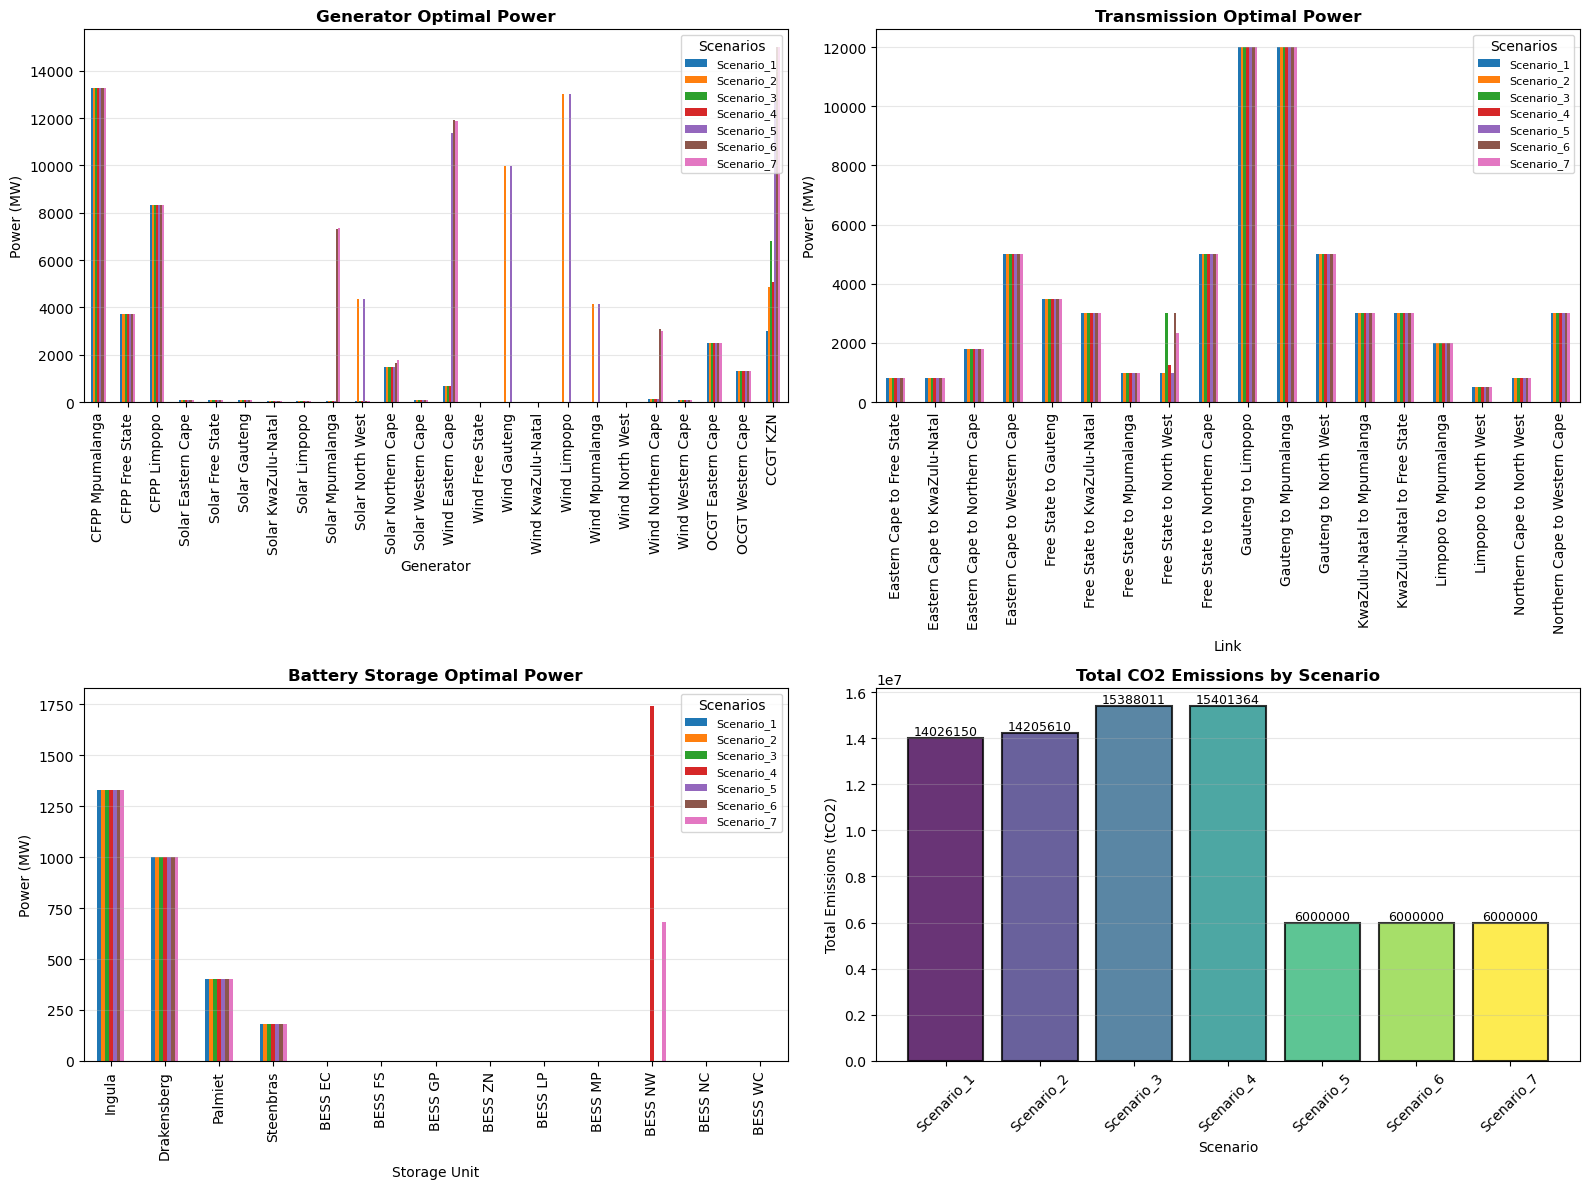

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Switch to matplotlib backend
pd.set_option('plotting.backend', 'matplotlib')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# Plot 1: Generator Optimal Power
df_p_nom_gen_opt.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Generator Optimal Power', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Power (MW)', fontsize=10)
axes[0, 0].set_xlabel('Generator', fontsize=10)
axes[0, 0].legend(title='Scenarios', fontsize=8, loc='upper right')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Transmission Optimal Power
df_p_nom_tx_opt.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Transmission Optimal Power', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Power (MW)', fontsize=10)
axes[0, 1].set_xlabel('Link', fontsize=10)
axes[0, 1].legend(title='Scenarios', fontsize=8, loc='upper right')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Battery Storage Optimal Power
df_p_nom_bess_opt.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Battery Storage Optimal Power', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Power (MW)', fontsize=10)
axes[1, 0].set_xlabel('Storage Unit', fontsize=10)
axes[1, 0].legend(title='Scenarios', fontsize=8, loc='upper right')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Total CO2 Emissions
scenarios = list(emissions_dict.keys())
emissions = list(emissions_dict.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(scenarios)))

axes[1, 1].bar(scenarios, emissions, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 1].set_title('Total CO2 Emissions by Scenario', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Total Emissions (tCO2)', fontsize=10)
axes[1, 1].set_xlabel('Scenario', fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for i, (scenario, emission) in enumerate(zip(scenarios, emissions)):
    axes[1, 1].text(i, emission, f'{emission:.0f}', ha='center', va='bottom', fontsize=9)

# Rotate x-axis labels for better readability
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Switch back to plotly if needed
pd.set_option('plotting.backend', 'plotly')